In [2]:
from divide_conquer import (
    resize_mask,
    coverage,
    smallest_square_containing_mask,
    NMS,
    setup_cfg,
    generate_feature_matrix,
    area,
)
from iterative_merging import iterative_merge
from cascadepsp import postprocess
from coco_annotator import create_annotation_info, output, category_info
from pycocotools import mask as mask_utils
from tqdm import tqdm
from detectron2.utils.colormap import random_color
import numpy as np
import segmentation_refinement as refine
from engine.defaults import DefaultPredictor
import PIL.Image as Image
import argparse
import torch
import dino
import cv2
import os

In [3]:
def get_parser(inputs):
    parser = argparse.ArgumentParser(description="")
    parser.add_argument(
        "--config-file",
        default="model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml",
        metavar="FILE",
    )
    # backbone args
    parser.add_argument("--patch-size", default=8, type=int)
    parser.add_argument("--feature-dim", default=768, type=int)
    parser.add_argument("--backbone-size", default="base", type=str)
    parser.add_argument(
        "--backbone-url",
        default="https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth",
        type=str,
    )

    parser.add_argument("--input-dir", type=str)
    parser.add_argument("--output-dir", type=str, default="pseudo_masks_output")
    parser.add_argument("--preprocess", default=None, type=bool)
    parser.add_argument("--postprocess", default=None, type=bool)
    # preprocess args
    parser.add_argument("--confidence-threshold", type=float, default=0.1)
    parser.add_argument("--start-id", default=None, type=int)
    parser.add_argument("--end-id", default=None, type=int)
    parser.add_argument("--local-size", default=256, type=int)
    parser.add_argument("--kept-thresh", default=0.9)
    parser.add_argument("--NMS-iou", default=0.9)
    parser.add_argument("--NMS-step", default=5)
    parser.add_argument("--thetas", default=[0.6, 0.5, 0.4, 0.3, 0.2, 0.1], type=list)
    # postprocess args
    parser.add_argument("--crop-ratio", default=2.0)
    parser.add_argument("--refine-scale", default=1)
    parser.add_argument("--refine-min-L", default=100)
    parser.add_argument("--refine-max-L", default=900)
    parser.add_argument("--iou-thresh", default=0.5)
    parser.add_argument("--min-area-thresh", default=0.0)
    parser.add_argument("--max-area-thresh", default=0.9)
    parser.add_argument("--cover-thresh", default=0.9)
    parser.add_argument(
        "--opts",
        help="Modify config options using the command-line 'KEY VALUE' pairs",
        default=[],
        nargs=argparse.REMAINDER,
    )
    args = parser.parse_args(inputs)
    return args

In [4]:
def vis_mask(input, mask, mask_color):
    fg = mask > 0.5
    rgb = np.copy(input)
    rgb[fg] = (rgb[fg] * 0.5 + np.array(mask_color) * 0.5).astype(np.uint8)
    return Image.fromarray(rgb)


def save_image(I, pool, output):
    # the visualization strategy is small masks on top of large masks
    already_painted = np.zeros(np.array(I).shape[:2])
    input = I.copy()
    i = 0
    for mask in tqdm(pool):
        already_painted += mask.astype(np.uint8)
        overlap = already_painted == 2
        if np.sum(overlap) != 0:
            input = Image.fromarray(
                overlap[:, :, np.newaxis] * np.copy(I)
                + np.logical_not(overlap)[:, :, np.newaxis] * np.copy(input)
            )
            already_painted -= overlap
        input = vis_mask(input, mask, random_color(rgb=True))
    input.save(output)

In [5]:
!wget http://dl.fbaipublicfiles.com/cutler/checkpoints/cutler_cascade_final.pth

--2024-06-29 23:05:43--  http://dl.fbaipublicfiles.com/cutler/checkpoints/cutler_cascade_final.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.238.154, 99.84.238.206, 99.84.238.162, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.238.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574672112 (548M) [binary/octet-stream]
Saving to: ‘cutler_cascade_final.pth’

cutler_cascade_fina 100%[===================>] 548.05M  36.3MB/s    in 16s     

2024-06-29 23:05:59 (34.9 MB/s) - ‘cutler_cascade_final.pth’ saved [574672112/574672112]



In [6]:
# Note: Using ***GPU*** by default. to run on GPU, add "MODEL.DEVICE", "cpu".
inputs = [
    "--backbone-url",
    "https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth",
    "--opts",
    "MODEL.WEIGHTS",
    "cutler_cascade_final.pth",
    "MODEL.DEVICE",
    "cuda",
]
args = get_parser(inputs)

In [7]:
# load the CutLER model
cfg = setup_cfg(args)
predictor = DefaultPredictor(cfg)

# load DINO backbone
backbone = dino.ViTFeat(
    args.backbone_url, args.feature_dim, args.backbone_size, "k", args.patch_size
)
backbone.eval()
if cfg.MODEL.DEVICE == "cpu":
    backbone.to("cpu")
else:
    backbone.cuda().to(torch.float16)

Downloading: "https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth" to /home/xudongw/.cache/torch/hub/checkpoints/dino_vitbase8_pretrain.pth
100%|██████████| 327M/327M [00:05<00:00, 64.4MB/s] 


Loading weight from https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth


In [25]:
# specify the path here if you want to try your own images
image = cv2.imread("../docs/demos/sa_234337.jpg")

In [26]:
# Divide phase
divide_conquer_masks = []
predictions = predictor(image)
divide_masks_tensor = predictions["instances"].get("pred_masks")
divide_masks = []
for i in range(divide_masks_tensor.shape[0]):
    divide_masks.append(divide_masks_tensor[i, :, :].cpu().numpy())
divide_conquer_masks.extend(divide_masks)

In [27]:
# Conquer phase
for divide_mask in tqdm(divide_masks):
    conquer_masks = []
    # find the bounding box and resize the original images
    ymin, ymax, xmin, xmax = smallest_square_containing_mask(divide_mask)
    if (ymax - ymin) <= 0 or (xmax - xmin) <= 0:
        continue
    local_image = image[ymin:ymax, xmin:xmax]
    resized_local_image = Image.fromarray(local_image).resize(
        [args.local_size, args.local_size]
    )

    feature_matrix = generate_feature_matrix(
        backbone,
        resized_local_image,
        args.feature_dim,
        args.local_size // args.patch_size,
    )
    merging_masks = iterative_merge(feature_matrix, args.thetas)

    for layer in merging_masks:
        if layer.shape[0] == 0:
            continue

        for i in range(layer.shape[0]):
            mask = layer[i, :, :]
            mask = resize_mask(mask, [xmax - xmin, ymax - ymin])
            mask = (mask > 0.5 * 255).astype(int)

            if coverage(mask, divide_mask[ymin:ymax, xmin:xmax]) <= args.kept_thresh:
                continue
            enlarged_mask = np.zeros_like(divide_mask)
            enlarged_mask[ymin:ymax, xmin:xmax] = mask
            conquer_masks.append(enlarged_mask)

    conquer_masks = NMS(conquer_masks, args.NMS_iou, args.NMS_step)
    divide_conquer_masks.extend(conquer_masks)

100%|██████████| 36/36 [00:22<00:00,  1.61it/s]


In [28]:
segmentation_id = 0
output["annotations"] = []
for m in divide_conquer_masks:
    # create coco-style annotation info
    annotation_info = create_annotation_info(
        segmentation_id, 0, category_info, m.astype(np.uint8), None
    )
    if annotation_info is not None:
        output["annotations"].append(annotation_info)
        segmentation_id += 1

In [29]:
# visualize annotations before postprocess
pre_masks = []
for ann in output["annotations"]:
    m = mask_utils.decode(ann["segmentation"])
    pre_masks.append(m)
pre_sorted_masks = sorted(pre_masks, key=lambda m: area(m), reverse=True)

In [30]:
# postprocess requires gpu
refiner = refine.Refiner(device="cuda:0")
refined_annotations = postprocess(args, refiner, output, image)

100%|██████████| 821/821 [01:57<00:00,  6.96it/s]


In [31]:
# visualize annotations after postprocess
masks = []
for ann in refined_annotations["annotations"]:
    m = mask_utils.decode(ann["segmentation"])
    masks.append(m)
sorted_masks = sorted(masks, key=lambda m: area(m), reverse=True)

# specify the output path to save image here
output_path = "postprocessed_demo.jpg"
save_image(image, sorted_masks, output_path)

100%|██████████| 599/599 [00:56<00:00, 10.55it/s]


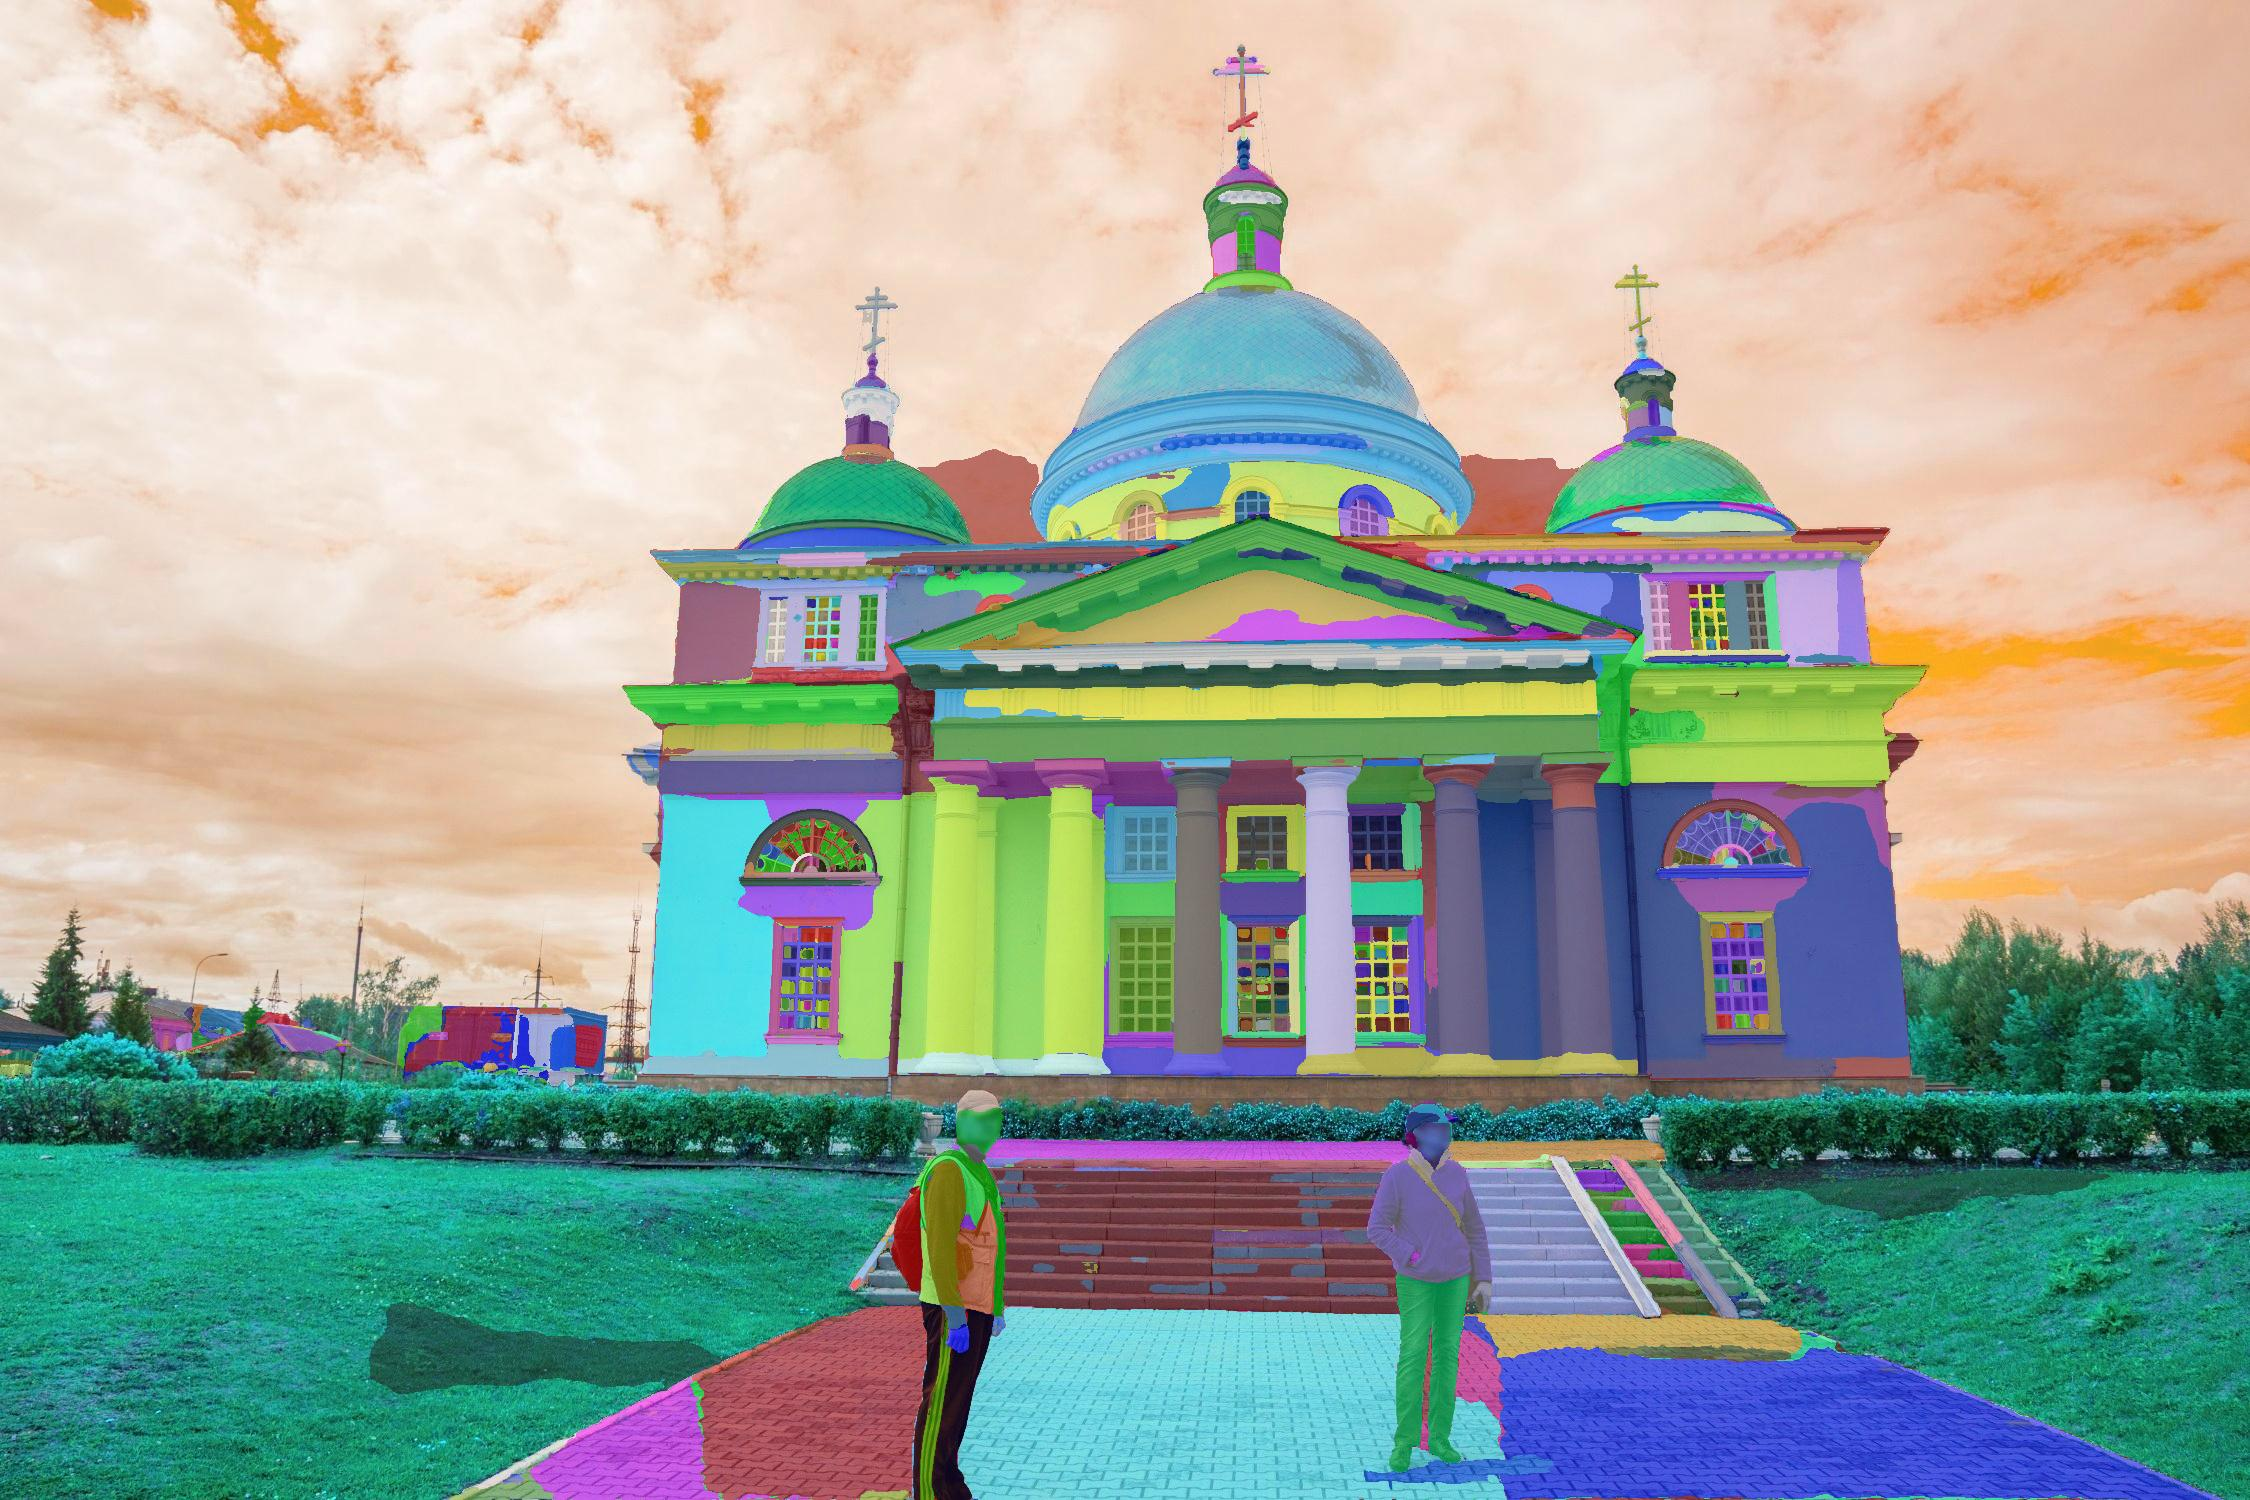

In [32]:
# show the image
Image.open(output_path)